In [126]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt

In [127]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(
    n_samples=200, centers=centers, cluster_std=0.4, random_state=0
)

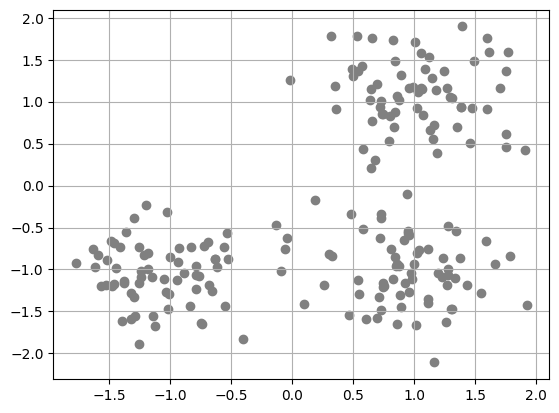

In [128]:
fig0, ax0 = plt.subplots()

ax0.scatter(X[:, 0], X[:, 1], c='grey')
ax0.grid(True)
plt.show()

Variables that influence the density-based clustering algorithm

epsilon:  maximum distance between two points to be considered neighbors

minPts:  minimum number of points required within neighborhood for a point to be considered a core point. 

In [129]:
eps = 0.3
min_pts = 4

In [130]:
def get_equclidean_distance(pt1, pt2):
    dist = np.sqrt(
        (pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2
        )
    
    return dist

Get core points

In [131]:
def get_core_points(data_set):

    core_points = []
    for center_idx, center_point in enumerate(data_set):

        center_neighbors = []
        for idx, neighbor_point in enumerate(data_set):

            #  ommits the center point from being considered
            if center_idx!=idx:
                dist = get_equclidean_distance(pt1=center_point, pt2=neighbor_point)

                #  Identify center points with neighboring points within distance epsilon
                if dist<=eps:
                    center_neighbors.append(neighbor_point)


        #  Of center points points with neighbors, identify center points with at least the miniumum number of neighbors as core points
        number_of_neighbors = len(center_neighbors)
        if number_of_neighbors>=min_pts:
            core_points.append(center_point)

    return core_points

In [132]:
core_points = get_core_points(data_set=X)

In [133]:
x = [point[0] for point in core_points]
y = [point[-1] for point in core_points]

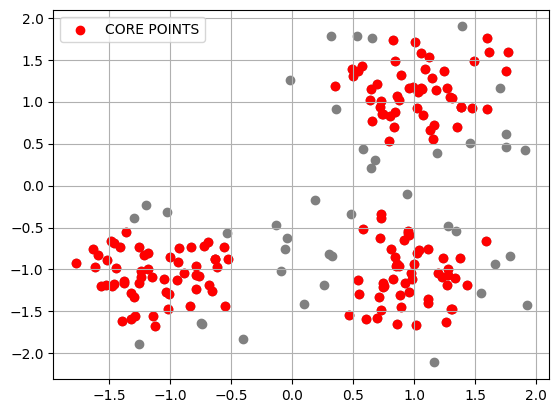

In [134]:
fig1, ax1 = plt.subplots()

ax1.scatter(X[:, 0], X[:, 1], c='grey')
ax1.scatter(x, y, c='red', label='CORE POINTS')
ax1.grid(True)
ax1.legend()
plt.show()

Get non-core neighbors

In [135]:
def get_non_core_points(data_set, core_points):
    
    non_core_points=[]
    for data_point in data_set:
        
        #  Identify core points in the input data set
        point_intersection=[]
        for core_point in core_points:
            common_pt = set(core_point)==set(data_point)
            point_intersection.append(common_pt)


        #  Only append values in the input data set that are NOT core points
        if not bool(sum(point_intersection)):
            non_core_points.append(data_point)

    return non_core_points

In [136]:
non_core_points = get_non_core_points(X, core_points)

In [137]:
#  non-core neighbors will join a cluster, but won't extend the cluster (i.e. will not make the cluster larger)
non_core_neighbors=[]

for nc_point in non_core_points:
    for c_point in core_points:

        dist = get_equclidean_distance(pt1=nc_point, pt2=c_point)
        
        #  Identify non-core points with neighboring core points within distance epsilon
        if dist<=eps:
            non_core_neighbors.append(nc_point)

In [138]:
p = [point[0] for point in non_core_neighbors]
q = [point[-1] for point in non_core_neighbors]

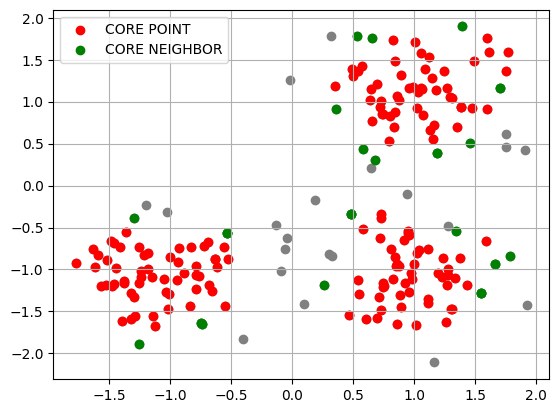

In [139]:
fig2, ax2 = plt.subplots()

ax2.scatter(X[:, 0], X[:, 1], c='grey')
ax2.scatter(x, y, c='red', label='CORE POINT')
ax2.scatter(p, q, c='green', label='CORE NEIGHBOR')
ax2.grid(True)
ax2.legend()
plt.show()

In [140]:
core_points.extend(non_core_neighbors)

x = [point[0] for point in core_points]
y = [point[-1] for point in core_points]

Identify outlier points

In [141]:
def get_outliers(data_set, core_points):
    
    outliers=[]
    for data_point in data_set:
        
        #  Identify outlier points in the input data set
        point_intersection=[]
        for core_point in core_points:
            common_pt = set(core_point)==set(data_point)
            point_intersection.append(common_pt)


        #  Only append values in the input data set that are NOT core points
        if not bool(sum(point_intersection)):
            outliers.append(data_point)

    return outliers

In [142]:
outliers = get_outliers(X, core_points)

In [143]:
r = [point[0] for point in outliers]
s = [point[-1] for point in outliers]

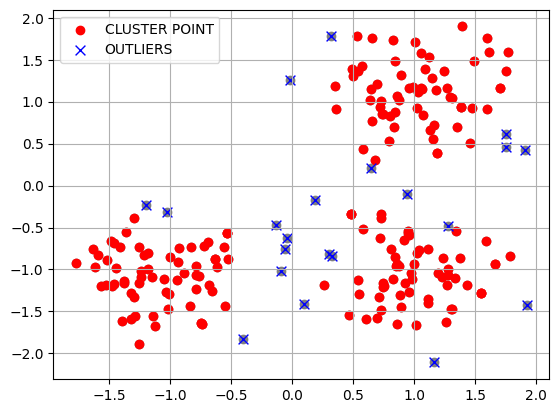

In [144]:
fig3, ax3 = plt.subplots()

ax3.scatter(X[:, 0], X[:, 1], c='grey')
ax3.scatter(x, y, c='red', label='CLUSTER POINT')
ax3.scatter(r, s, c='blue', marker='x',s=50, linewidth=1, label='OUTLIERS')
ax3.grid(True)
ax3.legend()
plt.show()

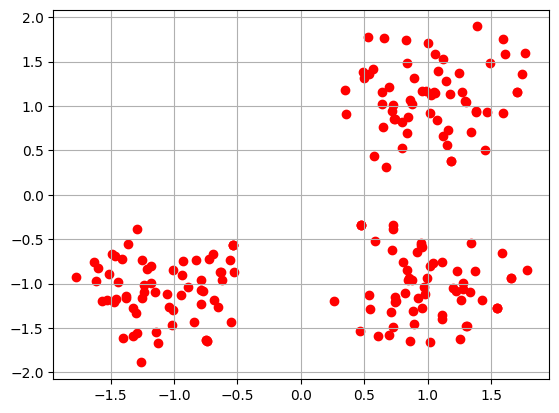

In [145]:
fig4, ax4 = plt.subplots()

ax4.scatter(x, y, c='red')
ax4.grid(True)
plt.show()

-----

build a dictionary where the key is a unique point index and the value is the point's coordinate

In [146]:
data_coords=dict()
for idx, point in enumerate(core_points):
    array2list = [float(pt) for pt in point]
    data_coords[idx]=array2list

build a table where the row and column intersection is the distance between the points corresponding to the row and column indices

In [147]:
def build_distance_table(row_count, col_count):

    distance_table = []
    for row_idx in range(row_count):

        row_data = []
        for col_idx in range(col_count):
            row_data.append((row_idx, col_idx))

        distance_table.append(row_data)

    return distance_table

In [148]:
data_point_count = len(data_coords.keys())
distance_table = build_distance_table(row_count=data_point_count, col_count=data_point_count)

calculate the distances between points

In [149]:
def get_distances(data_coords, distance_table):

    for row in distance_table:
        for col in row:

            row_idx = col[0]
            col_idx = col[-1]

            center_point = data_coords[row_idx]
            neighbor_point = data_coords[col_idx]

            dist = get_equclidean_distance(pt1=center_point, pt2=neighbor_point)
            distance_table[col[0]][col[-1]]=round(float(dist), 2)

    return distance_table

In [150]:
distance_table = get_distances(data_coords=data_coords, distance_table=distance_table)

In [151]:
#  get point_neighbors from distance table
point_neighbors = {row_idx:[] for row_idx, row in enumerate(distance_table)}
for row_idx, row in enumerate(distance_table):
    point_neighbors_check = [idx for idx, dist in enumerate(row) if dist<=eps]
    point_neighbors[row_idx]=point_neighbors_check

In [152]:
#  combine common neighbors' lists
clusters = {row_idx:[] for row_idx in point_neighbors.keys()}
for row_idx, row in point_neighbors.items():


    for neighbor_idx in row:
        neighbors_neighbors = point_neighbors[neighbor_idx]


        #  find values in row that are missing from neighbors_neighbors and add them in
        missing_vals = result = [x for x in row if x not in neighbors_neighbors]
        neighbors_neighbors.extend(missing_vals)
        clusters[neighbor_idx].extend(neighbors_neighbors)


        #  find values in neighbors_neighbors that are missing from row and add them in
        missing_vals = result = [x for x in neighbors_neighbors if x not in row]
        row.extend(missing_vals)
        clusters[row_idx].extend(row)

In [153]:
#  only unique values in the dictionary value lists
for key, val in clusters.items():
    clusters[key]=list(set(val))

In [154]:
#  get unique clusters
clusters_list=[]
for key, val in clusters.items():
    if val not in clusters_list:
        clusters_list.append(val)

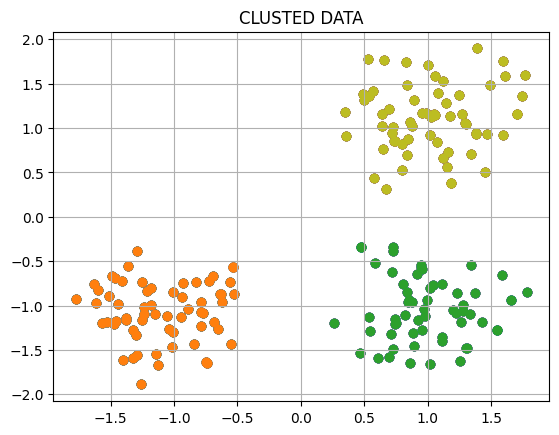

In [157]:
fig5, ax5 = plt.subplots()
for cluster_idx, cluster in enumerate(clusters_list):

    point_coordinates = [data_coords[cluster_point] for cluster_point in cluster]
    ax5.scatter(list(map(itemgetter(0), point_coordinates)), list(map(itemgetter(-1), point_coordinates)))

ax5.set_title('CLUSTED DATA')
plt.grid(True)
plt.show()
